# Netflix Challenge Embedding layer

## This notebook is intended as an example for embedding layers. The goal is to use part of the Netflix Challenge data to create a simple recommendation system and a meaningful embedding for the movies in the dataset.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import os
import tarfile
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import sys

Using TensorFlow backend.


# Data preperation 

## In this example our terminology will be:
    data - the part of the data we can build our model with.
        splitted into:
        - train - fitting the model
        - dev - evauate the model during development and tweaking
    probe - the original netflix self-test set for which RMSE were reported

In [2]:
data_df = pd.read_csv('resources/data/train.csv')

In [3]:
print(data_df.shape)
data_df.head()

(99072112, 3)


,user_id,movie_id,rating
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,823519,1,3
4,893988,1,3


In [4]:
probe_df = pd.read_csv('resources/data/probe.csv')

In [5]:
print(probe_df.shape)
probe_df.head()

(1408395, 3)


,user_id,movie_id,rating
0,30878,1,4
1,2647871,1,4
2,1283744,1,3
3,2488120,1,5
4,317050,1,5


## Exploration 

### Check rating distribution 

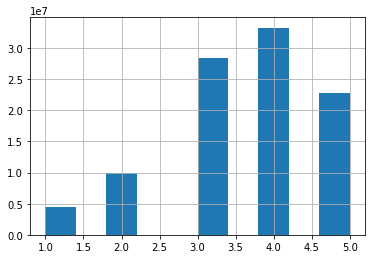

In [238]:
data_df.rating.hist()
plt.show()

### check amount of movies per user (select few to speed up)

In [243]:
sample_df = data_df.loc[:1e6, ['user_id', 'movie_id']]

In [274]:
movies_per_user = sample_df.groupby('user_id').count()
movies_per_user.columns = ['n_movies']

In [275]:
movies_per_user.describe()

,n_movies
count,269673.000000
mean,3.593511
std,3.748827
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,220.000000


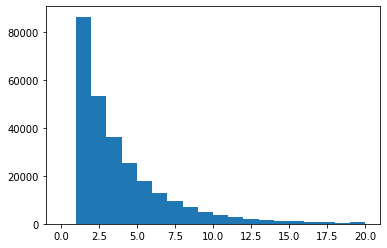

In [276]:
plt.hist(movies_per_user.values, range=(0,20), bins=20)
plt.show()

### check amount of users per movie 

In [277]:
users_per_movie = sample_df.groupby('movie_id').count()
users_per_movie.columns = ['n_users']
users_per_movie.describe()

,n_users
count,225.000000
mean,4306.991111
std,13586.346178
min,55.000000
25%,187.000000
50%,456.000000
75%,2269.000000
max,114055.000000


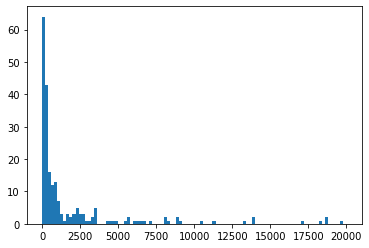

In [281]:
plt.hist(users_per_movie.values, bins=100, range=(0,20000))
plt.show()

## proceed with preprocessing 

In [6]:
X_train, X_dev, y_train, y_dev = train_test_split(data_df.drop('rating', axis = 1), data_df.rating, test_size = 0.3, random_state = 77)

#### we use all the user and movie IDs only to make sure the transformation encodes all movies and users, we don't use the ratings from this set 

#### here we create a new "transformed" column instead of the id, which is ordnial - the movies get numbers from 0 to num_of_movies and same for the users

In [7]:
#this cell creates dictionaries which help with changing the unique ID's into series of int's. 
#This is neccessary for embedding layers in keras (so use the transformed columns later on), 
#especially if you only use part of the data.

list_unique_user = list(set(data_df.user_id).union(set(probe_df.user_id)))
transforming_user = {v:k for k,v in zip(range(len(list_unique_user)), list_unique_user)}
inv_transforming_user = {k:v for k,v in zip(range(len(list_unique_user)), list_unique_user)}

list_unique_movie = list(set(data_df.movie_id).union(set(probe_df.movie_id)))
transforming_movie = {v:k for k,v in zip(range(len(list_unique_movie)), list_unique_movie)}
inv_transforming_movie = {k:v for k,v in zip(range(len(list_unique_movie)), list_unique_movie)}


In [8]:
X_train['user_id_transformed'] = X_train['user_id'].apply(lambda x: transforming_user[x])
X_train['movie_id_transformed'] = X_train['movie_id'].apply(lambda x: transforming_movie[x])

X_dev['user_id_transformed'] = X_dev['user_id'].apply(lambda x: transforming_user[x])
X_dev['movie_id_transformed'] = X_dev['movie_id'].apply(lambda x: transforming_movie[x])

In [9]:
num_of_users = transforming_user[list(transforming_user.keys())[-1]]
num_of_users

480188

In [10]:
num_of_movies = transforming_movie[list(transforming_movie.keys())[-1]]
num_of_movies

17769

In [11]:
X_train.head()

,user_id,movie_id,user_id_transformed,movie_id_transformed
9096243,2480985,1853,139369,1852
53603143,1075324,9954,295385,9953
13434724,906893,2650,264924,2649
63016666,257017,11677,92983,11676
60170577,1721379,11173,412397,11172


In [12]:
y_dev.head()

85733865    3
19059034    4
18459054    4
59155026    4
76136516    2
Name: rating, dtype: int64

# Create Keras model using functional API for predicting user score per movie

In [13]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam 
from keras.layers import LeakyReLU
from keras.utils import plot_model
from IPython.display import display, Image

In [14]:
batch_size = 2**19

In [ ]:
batches_per_epoch = X_train.shape[0]/batch_size
lr_decay = (1./0.75 -1)/batches_per_epoch
lr_decay

0.0025199922438410103

In [ ]:
# Model
movie_id_layer = Input(shape=(1,), dtype='int32', name='movie_id')

# ** the +1 in dim is because we need to encode the last valid value as well
movie_embedding_layer = Embedding(output_dim=60, input_dim=num_of_movies+1,
                                  input_length=1,
                                  name='movie_embedding',
                                 )(movie_id_layer)

user_id_layer = Input(shape=(1,), dtype='int32', name='user_id')

user_embedding_layer = Embedding(output_dim=20, input_dim=num_of_users+1,
                                 input_length=1,
                                 name='user_embedding',
                                )(user_id_layer)

x = keras.layers.Concatenate(axis=-1, name='concat_layer')([movie_embedding_layer, user_embedding_layer])

x = keras.layers.Flatten(name='flatten')(x)

x = Dense(1000 ,)(x)
x = LeakyReLU()(x)

x = Dense(1000 ,)(x)
x = LeakyReLU()(x)

x = Dense(10)(x)
x = LeakyReLU()(x)

output_layer = Dense(1,name='output')(x)

model = Model(inputs=[movie_id_layer, user_id_layer], outputs=output_layer)

model.compile(loss= "mean_squared_error" , optimizer=Adam(lr=0.004, decay=lr_decay), metrics=["mean_squared_error"])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 60)        1066200     movie_id[0][0]                   
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        9603780     user_id[0][0]                    
__________________________________________________________________________________________________
concat_lay

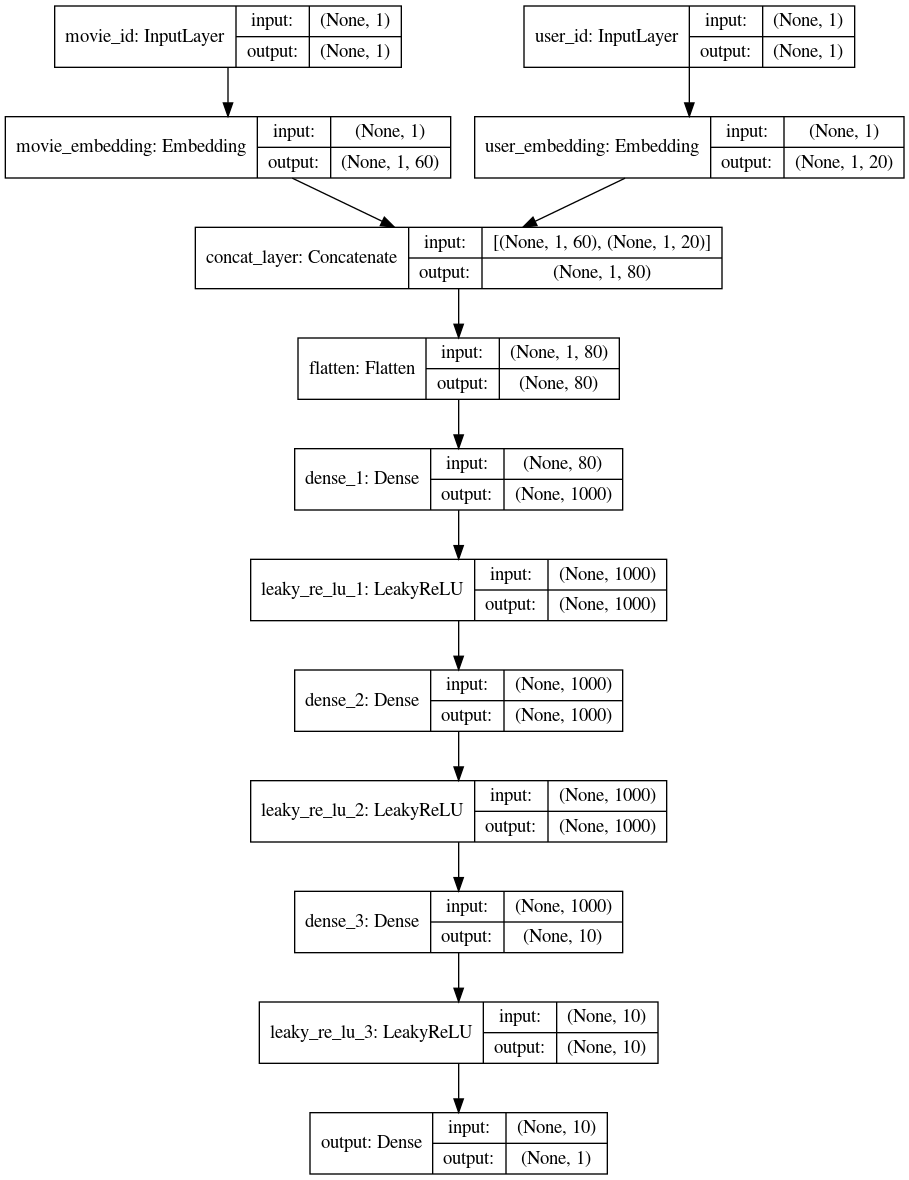

<Figure size 1224x1800 with 0 Axes>

In [31]:
plot_model(model, to_file='model.png', show_shapes=True)
display(Image(filename='model.png'))

In [ ]:
model.fit(x=[X_train.movie_id_transformed.values.reshape(-1,1),
             X_train.user_id_transformed.values.reshape(-1,1)],
            y=y_train,
            epochs=100,
            batch_size=batch_size,
            validation_data=([X_dev.movie_id_transformed.values.reshape(-1,1),
                       X_dev.user_id_transformed.values.reshape(-1,1)], 
                             y_dev.values))




Train on 69350478 samples, validate on 29721634 samples
Epoch 1/100





69350478/69350478 [==============================] - 57s 1us/step - loss: 1.6289 - mean_squared_error: 1.6289 - val_loss: 0.8572 - val_mean_squared_error: 0.8572
Epoch 2/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8513 - mean_squared_error: 0.8513 - val_loss: 0.8531 - val_mean_squared_error: 0.8531
Epoch 3/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8458 - mean_squared_error: 0.8458 - val_loss: 0.8498 - val_mean_squared_error: 0.8498
Epoch 4/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8378 - mean_squared_error: 0.8378 - val_loss: 0.8361 - val_mean_squared_error: 0.8361
Epoch 5/100
69350478/69350478 [==============================] - 47s 1us/step - loss: 0.8058 - mean_squared_error: 0.8058 - val_loss: 0.7993 - val_mean_squared_error: 0.7993
Epoch 6/100
69350478/69350478 [==============================] - 4

### Eval RMSE on probe data and save model 

In [12]:
from sklearn.metrics import mean_squared_error

In [235]:
RMSE_probe = np.sqrt(mean_squared_error(probe_df.rating, 
                   model.predict([probe_df['movie_id'].apply(lambda x: transforming_movie[x]).values.reshape(-1,1),
                                  probe_df['user_id'].apply(lambda x: transforming_user[x]).values.reshape(-1,1)
                                 ])))
print('RMSE for probe data is: {}'.format(RMSE_probe))

RMSE for probe data is: 0.997990271028259


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/model{0:.4g}.h5'.format(RMSE_probe))

In [ ]:
del X_dev, X_train
gc.collect()

In [ ]:
# from keras import backend as K
# K.clear_session()

# Continue from here if you have a saved model 

### don't forget to run all cells except for model.fit - we will need many of the defined variables 

In [15]:
model = keras.models.load_model('model0.9976.h5')

# Basic recommendation system

In [16]:
# load movie titles per movie id
movie_titles_df = pd.read_csv('resources/movie_titles_fixed.csv', names=['ID', 'name'], usecols=[0,2])
movie_titles_df.set_index('ID', inplace=True)
movie_titles_df.head()

,name
ID,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [17]:
def movie_per_user(model, user_id):
    
    # array of all movie counters (0 to number of movies)
    movie_counter_array = np.arange(num_of_movies).reshape(-1,1)
    
    # predict for all movies (and a single inputed user) what is the score
    preds = model.predict([movie_counter_array, np.ones_like(movie_counter_array)*transforming_user[user_id]])

    # find the 10 most highly ranked movies for that user
    highest_ranked_counter = preds.argsort(axis=0)[-10:]
    
    # transform from the ordinal id of the model to the id in the dataset
    vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
    highest_ranked_idx = vfunc(highest_ranked_counter)
    return movie_titles_df.loc[highest_ranked_idx.reshape(-1), :]
    

In [18]:
# movie recommendations for a single user
movie_per_user(model, 1608708)

,name
ID,
5582,Star Wars: Episode V: The Empire Strikes Back
14240,Lord of the Rings: The Return of the King
11521,Lord of the Rings: The Two Towers
8964,Trailer Park Boys: Season 4
4427,The West Wing: Season 3
7057,Lord of the Rings: The Two Towers: Extended Ed...
7230,The Lord of the Rings: The Fellowship of the R...
13556,The West Wing: Season 2
2114,Firefly


# Inspect the Movie embedding using clustering

#### Create a new model, using the trained layers of the existing one.
##### The new model gets a movie_id as an input and returns the embedding in lower dimention

In [19]:
movie_embedding_model = Model(inputs=model.get_layer('movie_id').input, outputs=model.get_layer('movie_embedding').output)

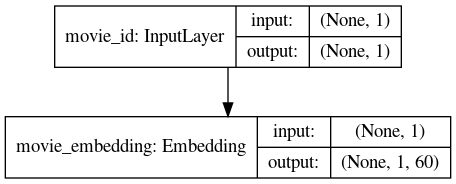

In [20]:
plot_model(movie_embedding_model, to_file='model_embedd.png', show_shapes=True)
display(Image(filename='model_embedd.png'))

In [21]:
# get embedding for all movies
movie_counter_array = np.arange(num_of_movies).reshape(-1,1)
movies_embeddings = movie_embedding_model.predict(movie_counter_array)

In [22]:
movies_embeddings.shape

(17769, 1, 60)

In [23]:
from sklearn.cluster import KMeans

### look at the content of many small clusters 

In [24]:
def get_movies_in_cluster(movie_clustering, n_cluster):
    """ return a list of movie titles that are in a certain cluster
    """
    # cluster num for each movie
    movie_clusters = movie_clustering.labels_.astype(float)
    
    # ordinal id of all movies in the cluster
    movie_count_ids = np.arange(num_of_movies)[movie_clusters==n_cluster]
    
    # retrieve from movie title list using the normal id
    vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
    movie_in_cluster_idx = vfunc(movie_count_ids)
    return movie_titles_df.loc[movie_in_cluster_idx.reshape(-1), :]

In [226]:
movie_clustering = KMeans(n_clusters=1000).fit(
            movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

In [228]:
get_movies_in_cluster(movie_clustering, 1)[:10]

,name
ID,
50,A Yank in the R.A.F.
508,Saint Jack
521,Presenting Felix the Cat
578,The Terror
1028,The Educational Archives: Vol. 1: Sex & Drugs
3460,Deathsport
3848,The Ghoul
4215,Alfred Hitchcock: Rich and Strange/The Sorcere...
4251,Drug Wars: The Camarena Story


In [230]:
get_movies_in_cluster(movie_clustering, 2)[:10]

,name
ID,
522,Love Songs
1439,The Three Pickers
2485,Race to Space
2732,Uprising
5820,True Women
5900,Cleopatra
6101,The Brooke Ellison Story
6943,Within These Walls
7972,Dancing in September


### Show a low dimention representation of the embedding 

In [25]:
movie_clustering = KMeans(n_clusters=10).fit(
            movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

#### PCA representation 

In [203]:
from sklearn.decomposition import PCA

In [204]:
movie_pca_2d_transformed_data = PCA(n_components=2).fit_transform(
    movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

In [205]:
movie_pca_2d_transformed_data.shape

(17770, 2)

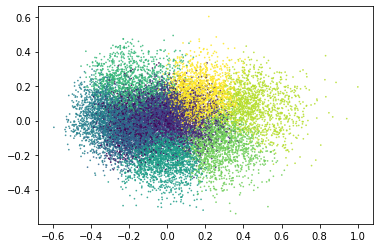

In [206]:
plt.scatter(movie_pca_2d_transformed_data[:,0], movie_pca_2d_transformed_data[:,1],
            c= movie_clustering.labels_.astype(float), s=0.5, alpha=0.8)
plt.show()

#### t-sne representation 

In [220]:
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNEp

In [222]:
movie_tsne_2d_transformed_data = TSNEp(perplexity=50, n_jobs=8).fit_transform(
    movies_embeddings.reshape(movies_embeddings.shape[0], movies_embeddings.shape[2]))

In [223]:
movie_tsne_2d_transformed_data.shape

(17770, 2)

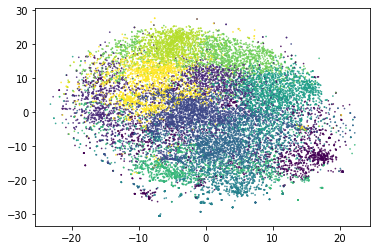

In [224]:
plt.scatter(movie_tsne_2d_transformed_data[:,0], movie_tsne_2d_transformed_data[:,1],
            c= movie_clustering.labels_.astype(float), s=0.5, alpha=0.8)
plt.show()

## Complex recommendation system - different "genres" of movies 

In [35]:
def get_recommendation_per_cluster(model, movie_clustering, user_id):
    """ return a list of movie titles that are in a certain cluster
    """
    # cluster num for each movie
    movie_clusters = movie_clustering.labels_.astype(float)
    
    
    hightest_ranked_movies_idxs = []
    
    # iterate over all clusters
    for n_cluster in np.unique(movie_clusters):
        
        # ordinal id of all movies in cluster
        movie_count_ids = np.arange(num_of_movies)[movie_clusters==n_cluster]

        # predict for all movies in cluster (and a single inputed user) what is the score
        preds = model.predict([movie_count_ids, np.ones_like(movie_count_ids)*transforming_user[user_id]])

        # find the most *predicted to be* highly ranked movie for that user and cluster
        highest_ranked_counter = preds.argsort(axis=0)[-1]

        # transform from the ordinal id of the model to the id in the dataset
        vfunc = np.vectorize(lambda x: inv_transforming_movie[x])
        highest_ranked_idx = vfunc(highest_ranked_counter)
        
        hightest_ranked_movies_idxs.append(highest_ranked_idx)
        
    hightest_ranked_movies_idxs = np.array(hightest_ranked_movies_idxs)
    
    return movie_titles_df.loc[hightest_ranked_movies_idxs.reshape(-1), :]

In [36]:
get_recommendation_per_cluster(model, movie_clustering, 1608708)

,name
ID,
907,Animal Crackers
833,White Squall
723,Curly Sue
320,Eat Your Heart Out
1236,Ali G Indahouse
561,High and Low
969,Stripteaser
1322,Yosemite: The World's Most Spectacular Valley
1097,Winning Strategies: Texas Hold 'Em Poker with ...


In [37]:
get_recommendation_per_cluster(model, movie_clustering, 1283744)

,name
ID,
328,Deftones: Live in Hawaii
59,Sex and the Beauties
290,Harold and Kumar Go to White Castle
138,Star Trek: Voyager: Season 1
1607,Superbabies: Baby Geniuses 2
111,Duplex (Widescreen)
583,Third Man on the Mountain
966,Young and Dangerous 2
1439,The Three Pickers
